In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [11]:
#Loading the data
company = 'TSLA'

start = dt.datetime(2013,1,1)
end = dt.datetime(2021,1,1)

data = web.DataReader(company, 'yahoo', start, end)
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-01-02,7.090000,6.942000,7.00000,7.072000,5974000.0,7.072000
2013-01-03,7.090000,6.950000,7.03600,6.954000,3710000.0,6.954000
2013-01-04,6.960000,6.784000,6.96000,6.880000,3370000.0,6.880000
2013-01-07,6.960000,6.780000,6.96000,6.868000,2210000.0,6.868000
2013-01-08,6.900000,6.622000,6.90000,6.736000,6420000.0,6.736000
...,...,...,...,...,...,...
2020-12-24,666.090027,641.000000,642.98999,661.770020,22865600.0,661.770020
2020-12-28,681.400024,660.799988,674.51001,663.690002,32278600.0,663.690002
2020-12-29,669.900024,655.000000,661.00000,665.989990,22910800.0,665.989990


In [17]:
#Since I will be using a RNN, I need to scale the data from 0-1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1)) #this line transforms
#array of closing values to a 2d array where each value is its own array


prediction_days = 100

In [24]:
x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x,0])
    y_train.append(scaled_data[x,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1))

In [55]:
#Building the Model
model = Sequential()

model.add(LSTM(units = 50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2)) #reduces overfitting
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units = 1)) #This is the prediction of the next closing stock price


model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size = 52)

Epoch 1/25
37/37 [==============================] - 15s 169ms/step - loss: 0.0100
Epoch 2/25
37/37 [==============================] - 5s 141ms/step - loss: 9.4123e-04
Epoch 3/25
37/37 [==============================] - 8s 221ms/step - loss: 9.5155e-04
Epoch 4/25
37/37 [==============================] - 6s 170ms/step - loss: 8.9386e-04
Epoch 5/25
37/37 [==============================] - 5s 130ms/step - loss: 9.5700e-04
Epoch 6/25
37/37 [==============================] - 5s 130ms/step - loss: 8.5167e-04
Epoch 7/25
37/37 [==============================] - 5s 147ms/step - loss: 6.6007e-04
Epoch 8/25
37/37 [==============================] - 5s 136ms/step - loss: 8.6470e-04
Epoch 9/25
37/37 [==============================] - 5s 130ms/step - loss: 9.8979e-04
Epoch 10/25
37/37 [==============================] - 5s 131ms/step - loss: 7.8583e-04
Epoch 11/25
37/37 [==============================] - 5s 144ms/step - loss: 9.1646e-04
Epoch 12/25
37/37 [==============================] - 5s 143ms/step

In [56]:
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)

model_inputs = scaler.transform(model_inputs)


In [57]:
#make predictions on test data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

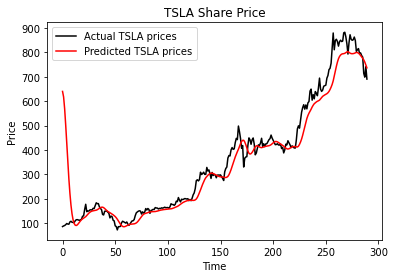

In [58]:
#Plotting the test predictions

plt.plot(actual_prices, color = 'black', label=f"Actual {company} prices")
plt.plot(prediction_prices, color = 'red', label=f"Predicted {company} prices")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [59]:
#Predicting the next day
real_data = [model_inputs[len(model_inputs)+1-prediction_days: len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

Prediction: [[724.8351]]
